In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import warnings
import os 

# Suppress warnings
warnings.filterwarnings("ignore")

# Define paths using direct C: address
# Note: Ensure your username replaces 'YourUsername' if the path differs
train_dir = r'C:\Users\Admin\Downloads\Alzhiemer - MRI Scan-20260220T094750Z-1-001\Alzhiemer - MRI Scan\train'
test_dir = r'C:\Users\Admin\Downloads\Alzhiemer - MRI Scan-20260220T094750Z-1-001\Alzhiemer - MRI Scan\test'

# 1. Define Transforms (Replacing ImageDataGenerator)
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    # Keras shear_range and shift_range are covered by Affine
    transforms.RandomAffine(
        degrees=90, 
        translate=(0.2, 0.2), 
        shear=0.4
    ),
    # RandomResizedCrop simulates the zoom_range logic
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)), 
    transforms.RandomHorizontalFlip(),
    # ToTensor() automatically rescales data to [0, 1]
    transforms.ToTensor(), 
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 2. Load Datasets
# This assumes the folders inside 'train' and 'test' are named after the classes
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transforms)

# 3. Create DataLoaders
# Setting num_workers to 0 is often safer on Windows to avoid Multiprocessing errors
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    shuffle=True, 
    num_workers=0
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=32, 
    shuffle=False, 
    num_workers=0
)

# Verify the setup
print(f"Dataset Classes: {train_dataset.classes}")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Dataset Classes: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
Number of training images: 5119
Number of test images: 1281


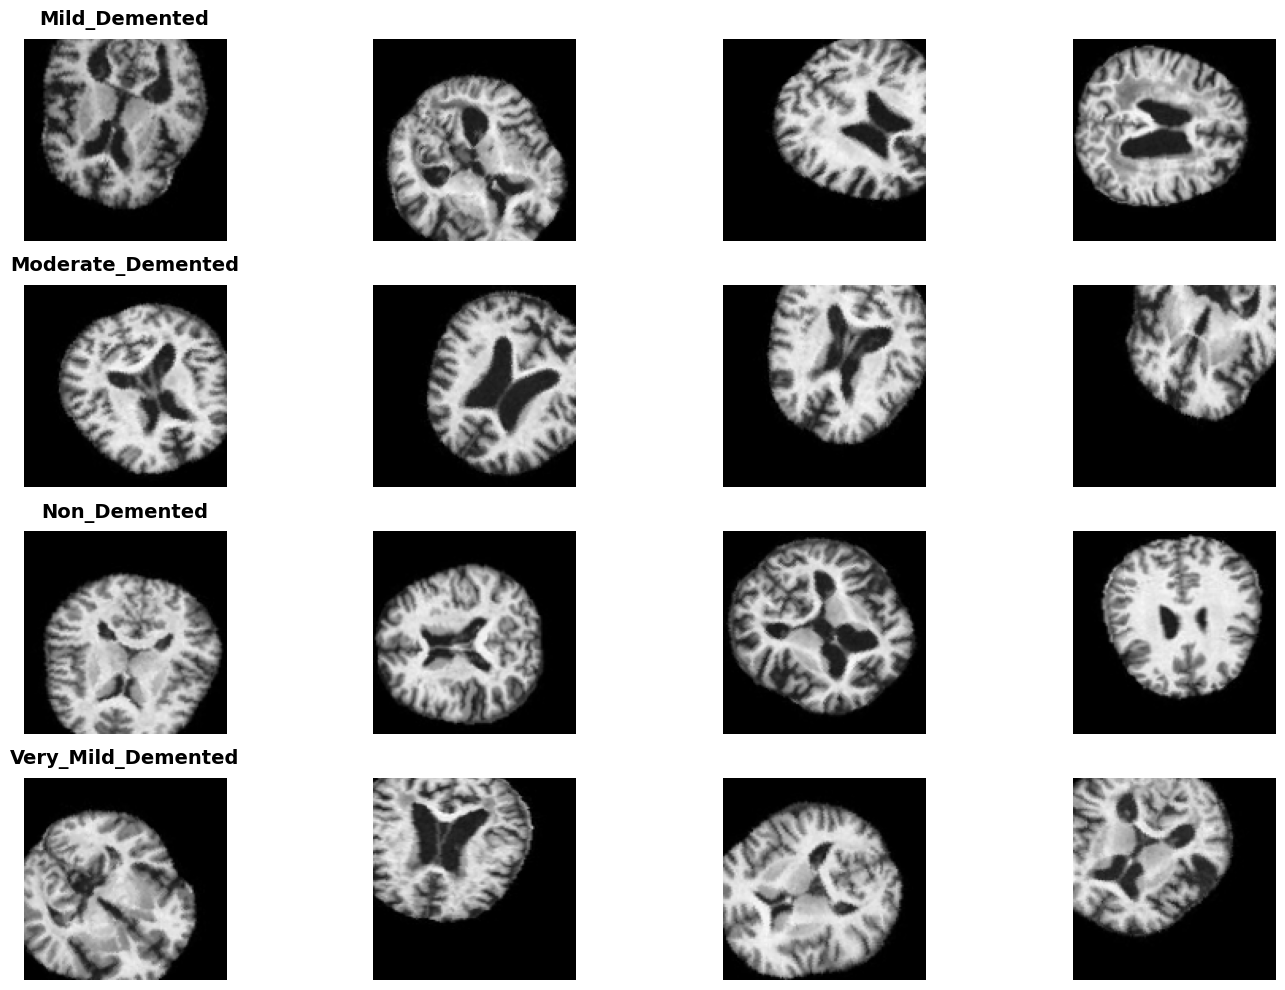

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Set the number of images to display per class
images_per_class = 4
classes = train_dataset.classes

# Set up the figure
fig, axes = plt.subplots(len(classes), images_per_class, figsize=(15, 10))

# Dictionary to keep track of how many images we've shown for each class
class_counts = {class_name: 0 for class_name in classes}

# Loop through the training dataset
for images, labels in train_loader:
    for i in range(len(images)):
        class_idx = labels[i].item()
        class_name = classes[class_idx]
        
        # Check if we still need more images for this class
        if class_counts[class_name] < images_per_class:
            ax = axes[class_idx, class_counts[class_name]]
            
            # PyTorch tensors are (C, H, W), Matplotlib needs (H, W, C)
            img = images[i].permute(1, 2, 0).numpy()
            
            # Undo normalization if you added transforms.Normalize later, 
            # but for now, ToTensor() leaves it at [0, 1]
            ax.imshow(img)
            ax.axis('off')
            
            # Add class title to the first image of the row
            if class_counts[class_name] == 0:
                ax.set_title(class_name, fontsize=14, weight='bold', loc='center', pad=10)
            
            class_counts[class_name] += 1
            
    # Break once all classes are filled
    if all(count >= images_per_class for count in class_counts.values()):
        break

plt.tight_layout()
plt.show()

## MedNet

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
           
        # Shared MLP layers
        self.fc = nn.Sequential(
            nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        # 2 input channels because we concat avg and max pools along the channel axis
        self.conv1 = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_out, max_out], dim=1)
        res = self.conv1(x_cat)
        return x * self.sigmoid(res)

class CBAMBlock(nn.Module):
    def __init__(self, in_planes, ratio=8, kernel_size=7):
        super(CBAMBlock, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        x = self.ca(x)
        x = self.sa(x)
        return x

In [8]:
import torch
import torch.nn as nn

class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=8):
        super(ChannelAttention, self).__init__()
        # Shared MLP layers
        self.shared_mlp = nn.Sequential(
            nn.Linear(in_planes, in_planes // ratio, bias=True),
            nn.ReLU(),
            nn.Linear(in_planes // ratio, in_planes, bias=True)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Global Average and Max Pooling
        # x is (Batch, Channels, H, W)
        avg_pool = torch.mean(x, dim=[2, 3]) # Result: (Batch, Channels)
        max_pool = torch.max(torch.max(x, dim=2)[0], dim=2)[0] # Result: (Batch, Channels)

        # Pass through shared MLP
        avg_out = self.shared_mlp(avg_pool)
        max_out = self.shared_mlp(max_pool)

        # Combine and Reshape to (Batch, Channels, 1, 1) for broadcasting
        out = (avg_out + max_out).unsqueeze(-1).unsqueeze(-1)
        return x * self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        # 2 input channels (avg + max)
        self.conv = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Reduction along the Channel axis (dim=1)
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        
        # Concatenate and Convolve
        concat = torch.cat([avg_out, max_out], dim=1)
        res = self.conv(concat)
        return x * self.sigmoid(res)

def cbam_block(in_planes):
    """
    In PyTorch, we usually return the module instance 
    to be used in nn.Sequential or a Model class.
    """
    return nn.Sequential(
        ChannelAttention(in_planes),
        SpatialAttention()
    )

In [9]:
# Example usage in a custom CNN
class AlzheimerModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.cbam = CBAMBlock(64) # Initialize with input channel count
        self.fc = nn.Linear(64 * 128 * 128, 4) # Assuming 4 classes

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.cbam(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

In [10]:
import torch
import torch.nn as nn
from torchvision import models

class MedNetAlzheimer(nn.Module):
    def __init__(self, num_classes=4):
        super(MedNetAlzheimer, self).__init__()
        
        # 1. Load MobileNetV2 backbone
        # weights='DEFAULT' is the modern equivalent of weights='imagenet'
        base_model = models.mobilenet_v2(weights='DEFAULT')
        
        # We only want the features (convolutional layers)
        self.features = base_model.features 
        
        # 2. CBAM Block
        # MobileNetV2 features end with 1280 channels
        self.cbam = CBAMBlock(in_planes=1280)
        
        # 3. Classification Head
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.classifier = nn.Sequential(
            nn.Linear(1280, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Forward through backbone
        x = self.features(x)
        
        # Apply Attention
        x = self.cbam(x)
        
        # Global Average Pool and Flatten
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        
        # Final Classification
        x = self.classifier(x)
        return x

# Instantiate the model
model = MedNetAlzheimer(num_classes=4)

# Define Optimizer and Loss (Replacing model.compile)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss() # Combines Softmax + CrossEntropy

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(model)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to C:\Users\Admin/.cache\torch\hub\checkpoints\mobilenet_v2-7ebf99e0.pth
100%|█████████████████████████████████████████████████████████████████████████████| 13.6M/13.6M [00:04<00:00, 3.55MB/s]


MedNetAlzheimer(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, 

In [15]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Standard MRI size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 1. Define Basic Preprocessing (equivalent to image_dataset_from_directory defaults)
data_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    # Note: image_dataset_from_directory usually keeps pixels 0-255 
    # but ToTensor() scales them to 0-1, which is standard for PyTorch.
])

# 2. Load the Datasets
train_dataset = datasets.ImageFolder(
    root=r'C:\Users\Admin\Downloads\Alzhiemer - MRI Scan-20260220T094750Z-1-001\Alzhiemer - MRI Scan\train',
    transform=data_transforms
)

# Note: Usually, you'd point this to a /val or /test folder
val_dataset = datasets.ImageFolder(
    root=r'C:\Users\Admin\Downloads\Alzhiemer - MRI Scan-20260220T094750Z-1-001\Alzhiemer - MRI Scan\test',
    transform=data_transforms
)

# 3. Create DataLoaders (Equivalent to Caching/Prefetching)
# num_workers > 0 enables multi-process data loading (Prefetching)
# pin_memory=True speeds up transfer to NVIDIA GPUs
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

print(f"Dataset classes: {train_dataset.classes}")

Dataset classes: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


In [17]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Standard MRI size
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 1. Define Basic Preprocessing (equivalent to image_dataset_from_directory defaults)
data_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    # Note: image_dataset_from_directory usually keeps pixels 0-255 
    # but ToTensor() scales them to 0-1, which is standard for PyTorch.
])

# 2. Load the Datasets
train_dataset = datasets.ImageFolder(
    root=r'C:\Users\Admin\Downloads\Alzhiemer - MRI Scan-20260220T094750Z-1-001\Alzhiemer - MRI Scan\test',
    transform=data_transforms
)

# Note: Usually, you'd point this to a /val or /test folder
val_dataset = datasets.ImageFolder(
    root=r'C:\Users\Admin\Downloads\Alzhiemer - MRI Scan-20260220T094750Z-1-001\Alzhiemer - MRI Scan\test',
    transform=data_transforms
)

# 3. Create DataLoaders (Equivalent to Caching/Prefetching)
# num_workers > 0 enables multi-process data loading (Prefetching)
# pin_memory=True speeds up transfer to NVIDIA GPUs
train_loader = DataLoader(
    train_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, 
    num_workers=4, 
    pin_memory=True 
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=4, 
    pin_memory=True
)

print(f"Dataset classes: {train_dataset.classes}")

Dataset classes: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


In [18]:
import numpy as np
import torch

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_model_state = None
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
                if self.restore_best_weights:
                    model.load_state_dict(self.best_model_state)
        else:
            self.best_loss = val_loss
            self.best_model_state = model.state_dict()
            self.counter = 0

In [19]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Move model to device (GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 1e-4 as requested
optimizer = Adam(model.parameters(), lr=1e-4)

# Equivalent to Keras ReduceLROnPlateau
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3, min_lr=1e-6)

# CrossEntropyLoss expects class indices, not one-hot (replaces categorical_crossentropy)
# If you have class_weights, pass them here: 
# criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights_list).to(device))
criterion = torch.nn.CrossEntropyLoss()

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)

In [23]:
import os
from tqdm import tqdm # Import tqdm

# Define the save directory
save_dir = r'C:\Users\Admin\Downloads\Alzheimer_Checkpoints'

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

epochs = 50

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train()
    train_loss = 0.0
    
    # Wrap train_loader with tqdm
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")
    
    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        # Update the progress bar with current loss
        train_bar.set_postfix(loss=loss.item())

    # --- VALIDATION PHASE ---
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    # Wrap val_loader with tqdm
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")
    
    with torch.no_grad():
        for images, labels in val_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Update progress bar with live accuracy
            val_bar.set_postfix(acc=f"{(100 * correct / total):.2f}%")

    avg_val_loss = val_loss / len(val_loader)
    avg_train_loss = train_loss / len(train_loader)
    accuracy = 100 * correct / total

    print(f'\nSummary Epoch {epoch+1}: Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {accuracy:.2f}%')

    # --- SAVE CHECKPOINT ---
    save_path = os.path.join(save_dir, f'mednet_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'val_loss': avg_val_loss,
        'val_acc': accuracy
    }, save_path)

    # Step the LR Scheduler and Early Stopping
    scheduler.step(avg_val_loss)
    early_stopping(avg_val_loss, model)
    
    if early_stopping.early_stop:
        print("Early stopping triggered")
        break

Epoch 1/50 [Val]: 100%|███████████████████████████████████████████████████| 41/41 [00:24<00:00,  1.65it/s, acc=100.00%]



Summary Epoch 1: Train Loss: 0.0805 | Val Loss: 0.0026 | Val Acc: 100.00%
Early stopping triggered


In [24]:
full_model_path = r'C:\Users\Admin\Downloads\full_mednet_model.pt'
torch.save(model, full_model_path)